# Explainability Methods

Machine learning models, especially those dealing with time series data, often operate as complex **black boxes**, making it challenging to interpret their decisions. Explainability methods play a crucial role in demystifying these models and enhancing their trustworthiness.

In this notebook, we'll explore key explainability techniques, implemented in out framework, including SHAP, and Time Series Points Perturbation Analysis.

Before we start with explainability methods, let's train two models: a simple statistical model and a complex one with several preprocessing nodes:

In [1]:
import numpy as np

from fedot_ind.api.main import FedotIndustrial as FI
from fedot_ind.tools.loader import DataLoader
from fedot_ind.tools.explain.explain import PointExplainer

available_operations=['scaling',
                   'normalization',
                   'xgboost',
                   'rfr',
                   'rf',
                   'logit',
                   'mlp',
                   'knn',
                   'lgbm',
                   'pca']

stat_model = FI(task='ts_classification',
                dataset='dataset',
                strategy='quantile',
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50)

topo_model = FI(task='ts_classification',
                dataset='dataset',
                strategy='topological',
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50)


comp_model = FI(task='ts_classification',
                dataset='dataset',
                strategy='fedot_preset',
                branch_nodes=['eigen_basis', 'fourier_basis'],
                tuning_iterations=2,
                tuning_timeout=2,
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50,
                available_operations=available_operations)

2023-12-20 13:54:23.466186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 13:54:27,342 INFO: FedotIndustrialAPI - Initialising experiment setup
2023-12-20 13:54:27,344 INFO: Configurator - Experiment setup:
2023-12-20 13:54:27,344 INFO: Configurator - task - ts_classification
2023-12-20 13:54:27,345 INFO: Configurator - dataset - dataset
2023-12-20 13:54:27,346 INFO: Configurator - strategy - quantile
2023-12-20 13:54:27,347 INFO: Configurator - use_cache - False
2023-12-20 13:54:27,348 INFO: FedotIndustrialAPI - Initialising solver
2023-12-20 13:54:27,350 INFO: TimeSeriesClassifier - TimeSeriesClassifier initialised
2023-12-20 13:54:27,352 INFO: FedotIndustrialAPI - Initialising experiment setup
2023-12-20 13:54:27,354 INFO: Configurator - 

2023-12-20 13:54:28,329 - TimeSeriesClassifierPreset initialised with [['eigen_basis', 'fourier_basis']] nodes and [2] tuning iterations and [2] timeout


## Synthetic data

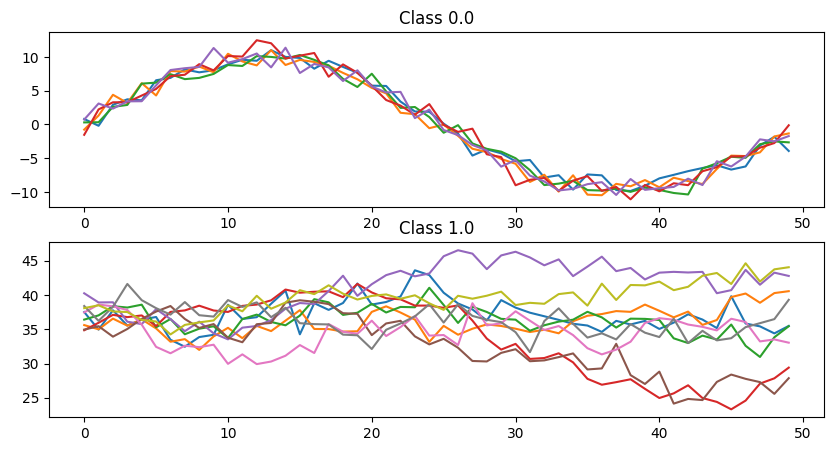

In [2]:
from fedot_ind.tools.synthetic.ts_datasets_generator import TimeSeriesDatasetsGenerator
import matplotlib.pyplot as plt
import numpy as np


generator = TimeSeriesDatasetsGenerator(num_samples=14,
                                        max_ts_len=50,
                                        binary=True)
train_data, test_data = generator.generate_data()
X_test, y_test = test_data
X_train, y_train = train_data

class_1 = np.unique(y_train)[0]
class_2 = np.unique(y_train)[1]
class_1_idx = np.where(y_train == class_1)[0]
class_2_idx = np.where(y_train == class_2)[0]
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(X_train.iloc[class_1_idx, :].T)
axs[0].set_title(f'Class {class_1}')
axs[1].plot(X_train.iloc[class_2_idx, :].T)
axs[1].set_title(f'Class {class_2}')
plt.show()


In [3]:
stat_model.fit(features=X_train, target=y_train)
stat_labels = stat_model.predict(features=X_test, target=y_test)
stat_probs = stat_model.predict_proba(features=X_test, target=y_test)
stat_model.get_metrics(target=y_test, metric_names=['roc_auc'])

2023-12-20 12:58:05,187 INFO: TimeSeriesClassifier - Fitting model


2023-12-20 12:58:05,187 - Fitting model


{'roc_auc': 1.0}

Processing points: 100%|██████████| 10/10 [00:01<00:00,  8.23point/s]


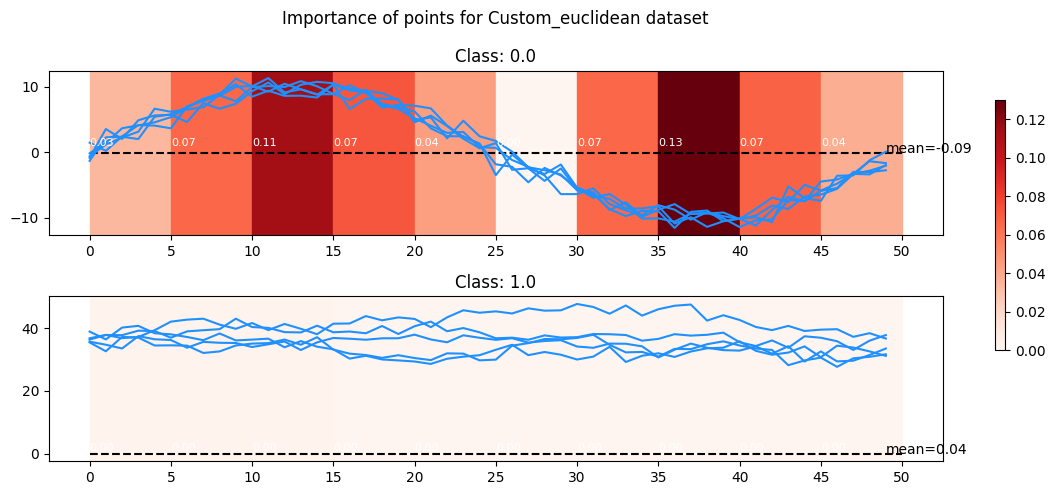

In [5]:
distance = 'euclidean'
explainer = PointExplainer(stat_model, X_test, y_test)
explainer.explain(n_samples=5, window=10, method=distance)
explainer.visual(threshold=0, name='Custom'+'_'+distance)

In [6]:
topo_model.fit(features=X_train, target=y_train)
topo_labels = topo_model.predict(features=X_test, target=y_test)
topo_probs = topo_model.predict_proba(features=X_test, target=y_test)
topo_model.get_metrics(target=y_test, metric_names=['roc_auc'])

{'roc_auc': 0.556}

Processing points: 100%|██████████| 10/10 [00:01<00:00,  5.42point/s]


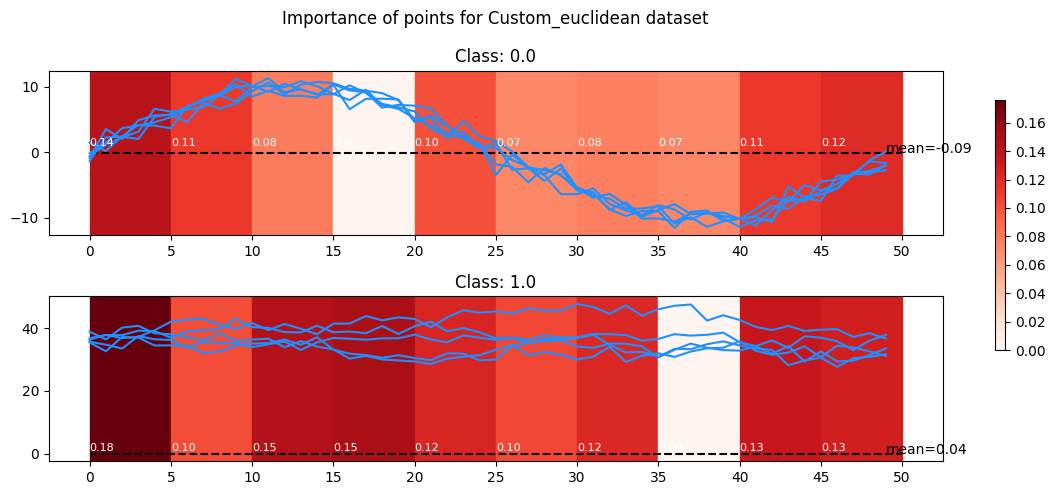

In [7]:
distance = 'euclidean'
explainer = PointExplainer(topo_model, X_test, y_test)
explainer.explain(n_samples=5, window=10, method=distance)
explainer.visual(threshold=0, name='Custom'+'_'+distance)

## Real data

In [2]:
from fedot_ind.api.main import FedotIndustrial as FI
from fedot_ind.tools.loader import DataLoader

dataset = 'Beef'
train_data, test_data = DataLoader(dataset).load_data()

X_test_beef, y_test_beef = test_data
X_train_beef, y_train_beef = train_data

2023-12-20 13:54:28,339 INFO: DataLoader - Reading data from /Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/fedot_ind/data/Beef


2023-12-20 13:54:28,339 - Reading data from /Users/technocreep/Desktop/Working-Folder/fedot-industrial/Fedot.Industrial/fedot_ind/data/Beef


2023-12-20 13:54:28,388 INFO: DataLoader - Data readed successfully from local folder


2023-12-20 13:54:28,388 - Data readed successfully from local folder


In [3]:
stat_model_beef = FI(task='ts_classification',
                dataset='Beef',
                strategy='quantile',
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50)

stat_model_beef.fit(features=X_train_beef, target=y_train_beef)
stat_labels_beef = stat_model_beef.predict(features=X_test_beef, target=y_test_beef)
stat_probs_beef = stat_model_beef.predict_proba(features=X_test_beef, target=y_test_beef)
stat_model_beef.get_metrics(target=y_test_beef, metric_names=['f1'])

2023-12-20 13:54:28,398 INFO: FedotIndustrialAPI - Initialising experiment setup


2023-12-20 13:54:28,398 - Initialising experiment setup


2023-12-20 13:54:28,404 INFO: Configurator - Experiment setup:


2023-12-20 13:54:28,404 - Experiment setup:


2023-12-20 13:54:28,407 INFO: Configurator - task - ts_classification


2023-12-20 13:54:28,407 - task - ts_classification


2023-12-20 13:54:28,410 INFO: Configurator - dataset - Beef


2023-12-20 13:54:28,410 - dataset - Beef


2023-12-20 13:54:28,413 INFO: Configurator - strategy - quantile


2023-12-20 13:54:28,413 - strategy - quantile


2023-12-20 13:54:28,415 INFO: Configurator - branch_nodes - ['eigen_basis', 'fourier_basis']


2023-12-20 13:54:28,415 - branch_nodes - ['eigen_basis', 'fourier_basis']


2023-12-20 13:54:28,417 INFO: Configurator - use_cache - False


2023-12-20 13:54:28,417 - use_cache - False


2023-12-20 13:54:28,419 INFO: FedotIndustrialAPI - Initialising solver


2023-12-20 13:54:28,419 - Initialising solver


2023-12-20 13:54:28,422 INFO: TimeSeriesClassifier - TimeSeriesClassifier initialised


2023-12-20 13:54:28,422 - TimeSeriesClassifier initialised


2023-12-20 13:54:28,424 INFO: TimeSeriesClassifier - Fitting model


2023-12-20 13:54:28,424 - Fitting model


{'f1': 0.452}

Processing points: 100%|██████████| 10/10 [00:03<00:00,  3.21point/s]


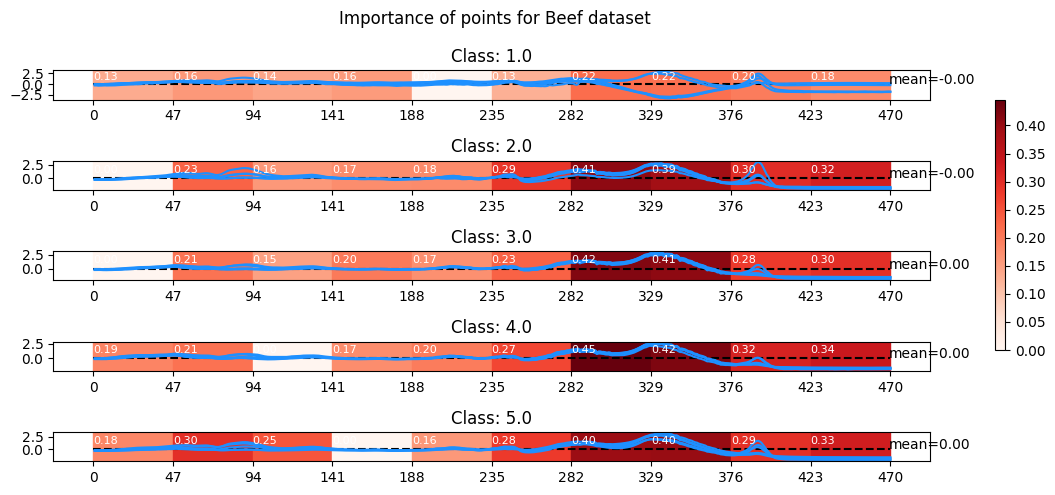

In [4]:
from fedot_ind.tools.explain.explain import PointExplainer

distance = 'euclidean'
explainer_stat_beef = PointExplainer(stat_model_beef, X_test_beef, y_test_beef)
explainer_stat_beef.explain(n_samples=5, window=10, method=distance)
explainer_stat_beef.visual(threshold=0, name='Beef')

In [5]:
comp_model_beef = FI(task='ts_classification',
                dataset='Beef',
                strategy='fedot_preset',
                branch_nodes=['eigen_basis'],
                tuning_iterations=5,
                tuning_timeout=3,
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50,
                available_operations=available_operations)

comp_model_beef.fit(features=X_train_beef, target=y_train_beef)
comp_labels_beef = comp_model_beef.predict(features=X_test_beef, target=y_test_beef)
comp_probs_beef = comp_model_beef.predict_proba(features=X_test_beef, target=y_test_beef)
comp_model_beef.get_metrics(target=y_test_beef, metric_names=['f1'])

100%|██████████| 2/2 [00:03<00:00,  1.80s/trial, best loss: -0.4444444444444444] 


{'f1': 0.568}

Processing points: 100%|██████████| 10/10 [00:14<00:00,  1.49s/point]


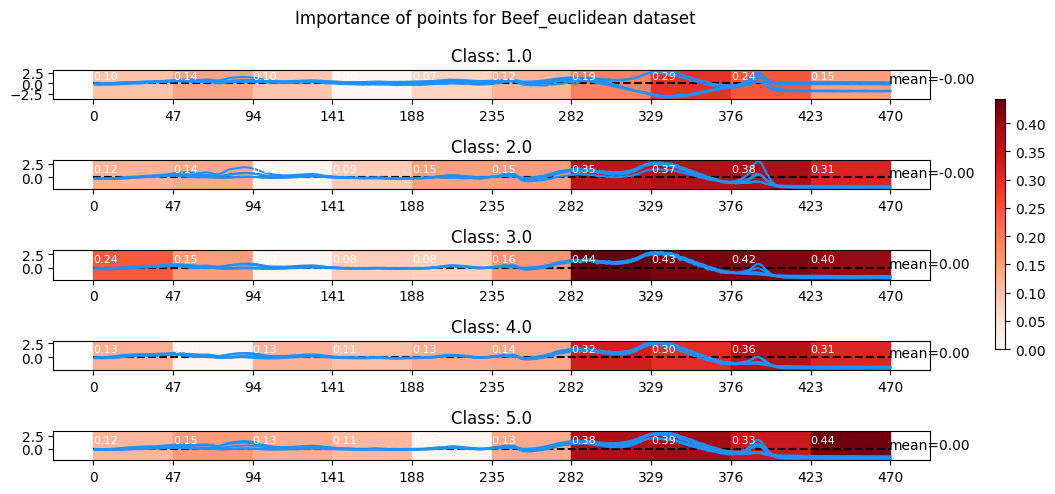

In [6]:
distance = 'euclidean'
explainer_comp_beef = PointExplainer(comp_model_beef, X_test_beef, y_test_beef)
explainer_comp_beef.explain(n_samples=5, window=10, method=distance)
explainer_comp_beef.visual(threshold=0, name='Beef'+'_'+distance)

In [7]:
from fedot_ind.api.main import FedotIndustrial as FI
from fedot_ind.tools.loader import DataLoader

dataset = 'Car'
train_data, test_data = DataLoader(dataset).load_data()
available_operations_=['scaling',
                   'normalization',
                   'xgboost',
                   'rfr',
                   # 'rf',
                   'logit',
                   'mlp',
                   'knn',
                   'lgbm',
                   'pca']

X_test_car, y_test_car = test_data
X_train_car, y_train_car = train_data

stat_model_car = FI(task='ts_classification',
                dataset='Car',
                strategy='quantile',
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50,
                available_operations=available_operations_)

stat_model_car.fit(features=X_train_car, target=y_train_car)
stat_labels_car = stat_model_car.predict(features=X_test_car, target=y_test_car)
stat_probs_car = stat_model_car.predict_proba(features=X_test_car, target=y_test_car)
stat_model_car.get_metrics(target=y_test_car, metric_names=['f1'])

Generations:   0%|          | 0/10000 [00:14<?, ?gen/s]


{'f1': 0.645}

Processing points: 100%|██████████| 11/11 [00:03<00:00,  3.09point/s]


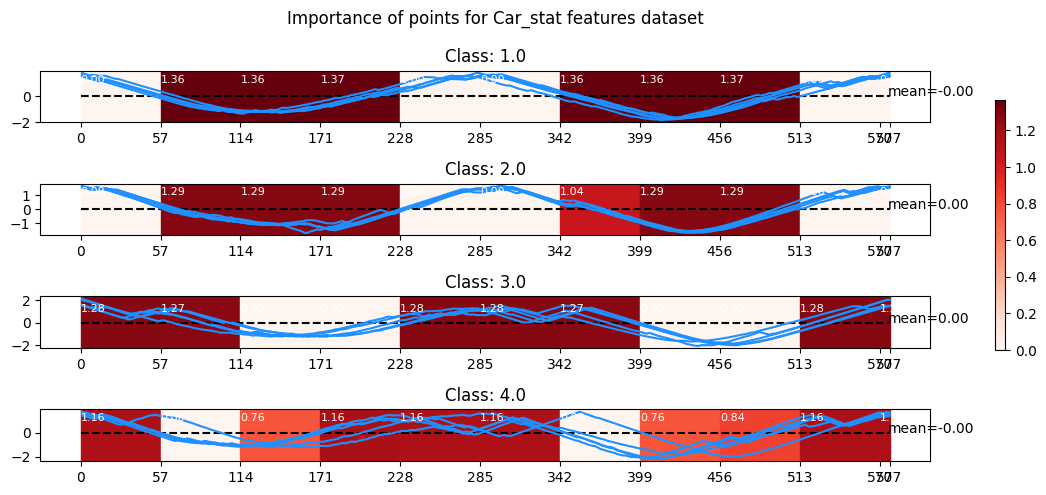

In [9]:
explainer_stat_car = PointExplainer(stat_model_car, X_test_car, y_test_car)
explainer_stat_car.explain(n_samples=5, window=10, method='euclidean')
explainer_stat_car.visual(threshold=0, name='Car'+'_'+'stat features')

In [10]:
train_data, test_data = DataLoader('Car').load_data()
available_operations_=['scaling',
                   'normalization',
                   'xgboost',
                   'rfr',
                   'rf',
                   'logit',
                   'mlp',
                   'knn',
                   'lgbm',
                   'pca']

X_test_car, y_test_car = test_data
X_train_car, y_train_car = train_data
comp_model_car = FI(task='ts_classification',
                dataset='Car',
                strategy='fedot_preset',
                branch_nodes=['eigen_basis'],
                tuning_iterations=5,
                tuning_timeout=3,
                use_cache=False,
                timeout=0.1,
                n_jobs=-1,
                logging_level=50,
                available_operations=available_operations_)

comp_model_car.fit(features=X_train_car, target=y_train_car)
comp_labels_car = comp_model_car.predict(features=X_test_car, target=y_test_car)
comp_probs_car = comp_model_car.predict_proba(features=X_test_car, target=y_test_car)
comp_model_car.get_metrics(target=y_test_car, metric_names=['f1'])

100%|██████████| 2/2 [00:18<00:00,  9.25s/trial, best loss: -0.912962962962963] 


{'f1': 0.862}

Processing points: 100%|██████████| 11/11 [02:32<00:00, 13.87s/point]


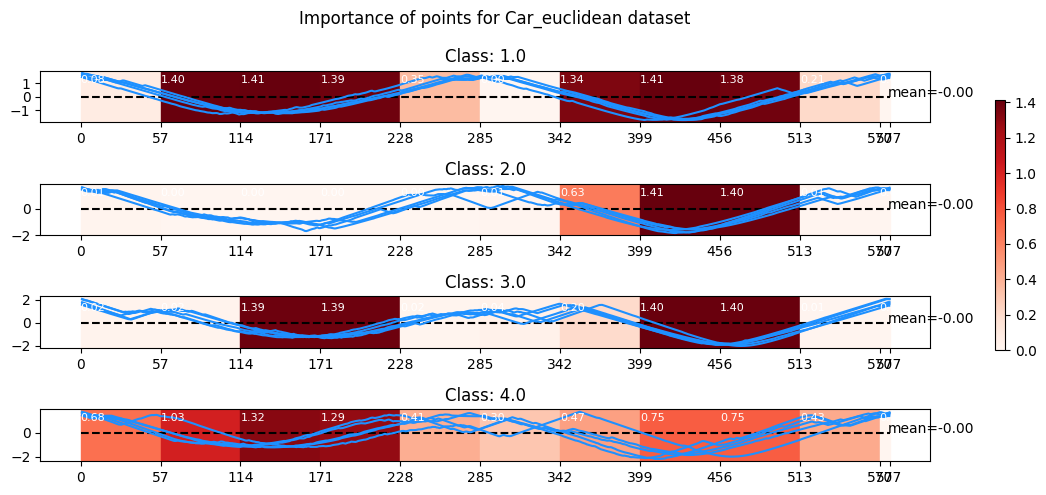

In [11]:
explainer_comp_car = PointExplainer(comp_model_car, X_test_car, y_test_car)
explainer_comp_car.explain(n_samples=5, window=10, method='euclidean')
explainer_comp_car.visual(threshold=0, name='Car'+'_'+'euclidean')

In [42]:
left = 228
right = 456

train_data, test_data = DataLoader('Car').load_data()
X_test_car_short, y_test_car = test_data[0].iloc[:, left:right], test_data[1]
X_train_car_short, y_train_car = train_data[0].iloc[:, left:right], train_data[1]

X_test_car_short.columns = np.arange(0, X_test_car_short.shape[1])
X_train_car_short.columns = np.arange(0, X_train_car_short.shape[1])


comp_model_car_short = FI(task='ts_classification',
                dataset='Car',
                strategy='quantile',
                window_size=10,
                # strategy='fedot_preset',
                # branch_nodes=['eigen_basis'],
                # tuning_iterations=5,
                # tuning_timeout=3,
                use_cache=False,
                timeout=1,
                n_jobs=-1,
                logging_level=50,
                available_operations=available_operations_)

comp_model_car_short.fit(features=X_train_car_short, target=y_train_car)
comp_labels_car_short = comp_model_car_short.predict(features=X_test_car_short, target=y_test_car)
comp_probs_car_short = comp_model_car_short.predict_proba(features=X_test_car_short, target=y_test_car)
comp_model_car_short.get_metrics(target=y_test_car, metric_names=['f1'])

Generations:   0%|          | 1/10000 [01:04<?, ?gen/s]


{'f1': 0.756}

In [44]:
comp_model_car_short.solver.test_features.shape

(60, 640)

Processing points: 100%|██████████| 10/10 [00:07<00:00,  1.34point/s]


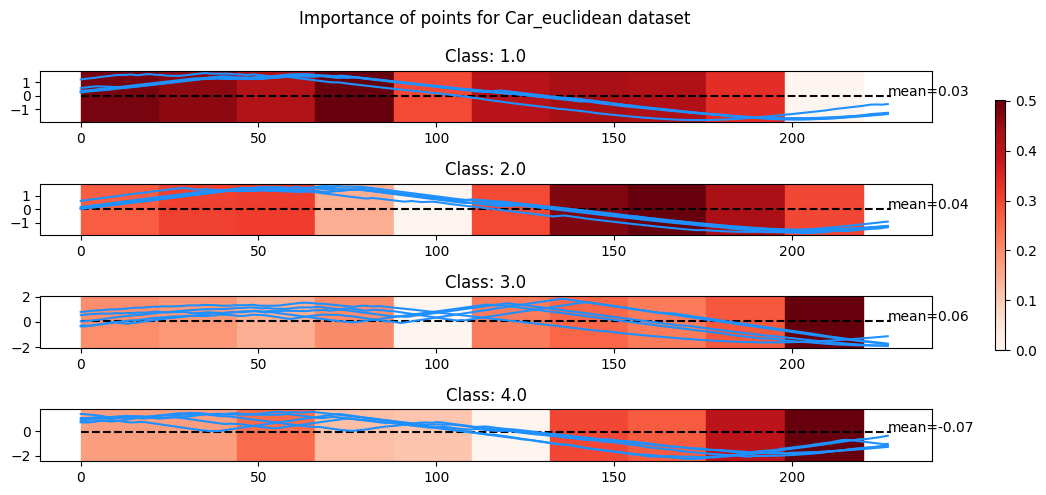

In [45]:
explainer_comp_car_short = PointExplainer(comp_model_car_short, X_test_car_short, y_test_car)
explainer_comp_car_short.explain(n_samples=5, window=10, method='euclidean', name='Car')
explainer_comp_car_short.visual(threshold=0, name='Car'+'_'+'euclidean')

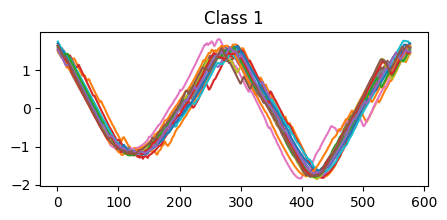

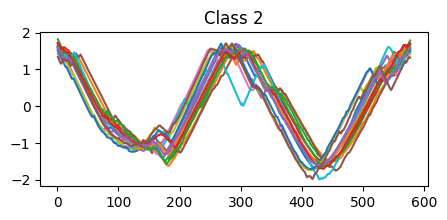

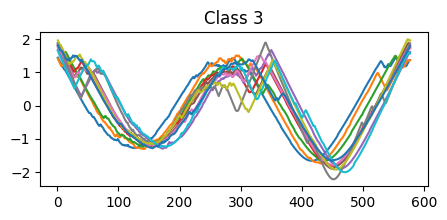

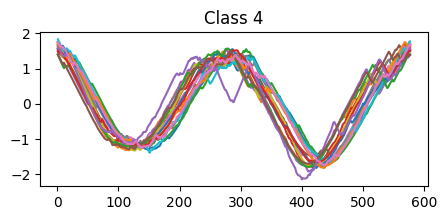

In [20]:
import numpy as np
import matplotlib.pyplot as plt
car_classes = np.unique(y_train_car)

for cls in car_classes:
    cls_idx = np.where(y_train_car == cls)[0]
    X_train_car.iloc[cls_idx, :].T.plot(figsize=(5,2), title=f'Class {cls}', legend=None)
    plt.show()

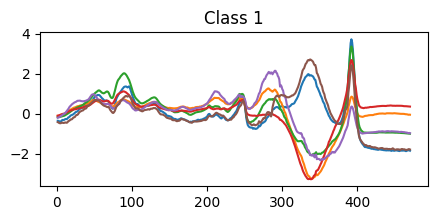

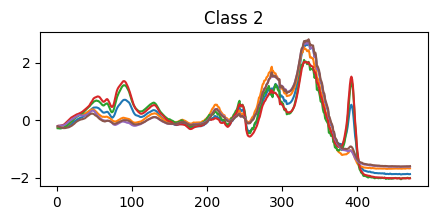

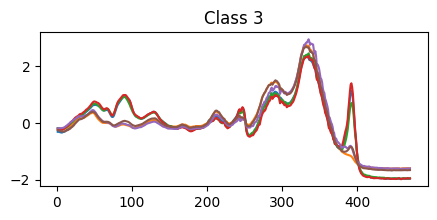

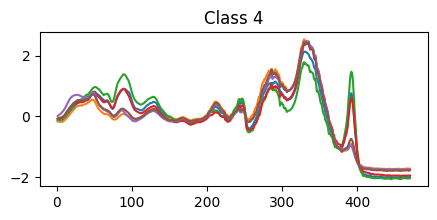

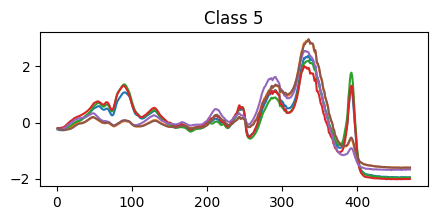

In [16]:
import numpy as np
import matplotlib.pyplot as plt
beef_classes = np.unique(y_train_beef)

for cls in beef_classes:
    cls_idx = np.where(y_train_beef == cls)[0]
    X_train_beef.iloc[cls_idx, :].T.plot(figsize=(5,2), title=f'Class {cls}', legend=None)
    plt.show()

<Axes: >

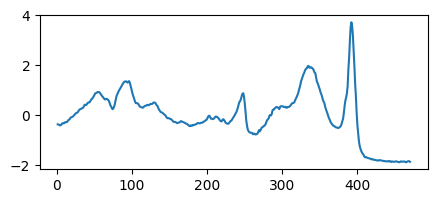

In [71]:
dataset = 'Beef'
train_data, test_data = DataLoader(dataset).load_data()

X_test_beef, y_test_beef = test_data
X_train_beef, y_train_beef = train_data

ts = X_train_beef.iloc[0, :].copy()
ts.plot(figsize=(5,2))

<Axes: >

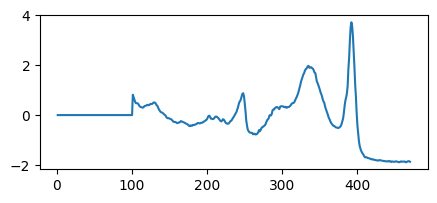

In [64]:
ts[0:100] = np.mean(ts)
ts.plot(figsize=(5,2))

<Axes: >

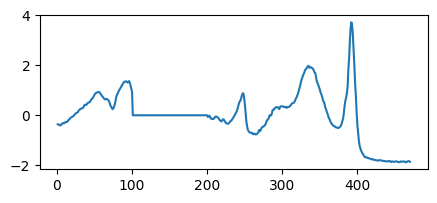

In [69]:
ts[100:200] = np.mean(ts)
ts.plot(figsize=(5,2))

<Axes: >

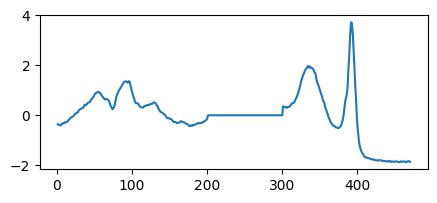

In [72]:
ts[200:300] = np.mean(ts)
ts.plot(figsize=(5,2))

## SHAP (SHapley Additive exPlanations)

SHAP values offer a game-theoretic approach to assign a value to each feature's contribution to a model's prediction.
In the context of time series, SHAP values can be calculated for individual time points or across the entire sequence. The formula for calculating SHAP values is given by:

$$\phi_i(f) = \sum_{S \subseteq N \setminus \{i\}} \frac{{|S| - 1}! \cdot (|N| - |S| - 1)!}{|N|!} [f(S \cup \{i\}) - f(S)] $$

where:

- $f(S)$ is the model's output when considering only the features in set $S$,
- $N$ is the set of all features, and
- $i$ is the feature for which we are calculating the SHAP value.


In our case for statistical model we can explore SHAP values for each feature, extracted by QuantileExtractor. Here they are:

In [4]:
display(stat_model.solver.test_features)

,skewness_,kurtosis_,n_peaks_,slope_,ben_corr_,interquartile_range_,energy_,cross_rate_,autocorrelation_,shannon_entropy_,...,petrosian_fractal_dimension_,mean_,median_,std_,max_,min_,q5_,q25_,q75_,q95_
0,-0.350659,0.361394,51.0,-0.003248,0.959372,0.704565,0.997872,0.029787,0.994638,8.842474,...,0.622998,-7.765958e-10,0.140019,0.998936,2.448200,-1.943663,-1.907868,-0.192094,0.512471,1.578451
1,-2.003292,3.390948,40.0,-0.002255,0.746639,0.308500,0.997872,0.004255,0.998845,8.872262,...,0.638446,-3.636170e-10,0.280685,0.998936,1.385611,-3.343694,-2.729292,0.124506,0.433006,0.997197
2,-1.304637,1.929469,29.0,-0.003378,0.762244,0.779684,0.997872,0.008511,0.997295,8.876517,...,0.659993,5.757447e-10,0.230815,0.998936,2.459545,-3.018348,-2.478581,-0.230480,0.549203,1.248810
3,-0.692359,0.099559,32.0,-0.004400,0.832135,1.423033,0.997872,0.012766,0.996090,8.859496,...,0.653261,4.687022e-10,0.224913,0.998936,2.368445,-2.495473,-2.162264,-0.761656,0.661378,1.299882
4,-2.138024,3.671746,36.0,-0.002453,0.801914,0.386153,0.997872,0.004255,0.998477,8.872262,...,0.645365,2.723404e-10,0.314075,0.998936,1.294925,-3.385794,-2.745254,0.116988,0.503141,0.827501
5,0.382660,0.956841,63.0,-0.001735,0.989721,0.800253,0.997872,0.021277,0.994082,8.842474,...,0.609642,6.080851e-10,-0.064324,0.998936,2.914151,-1.814624,-1.751914,-0.357905,0.442348,1.899067
6,-0.146153,0.529319,46.0,-0.002617,0.986619,0.722207,0.997872,0.029787,0.994770,8.876517,...,0.628114,-6.553192e-10,0.091592,0.998936,2.576844,-1.909445,-1.892857,-0.251989,0.470217,1.706002
7,0.196881,0.330647,45.0,-0.002130,0.950238,0.475943,0.997872,0.004255,0.996540,8.872262,...,0.629474,-7.325529e-11,0.037003,0.998936,2.628389,-1.707133,-1.692649,-0.205631,0.270312,1.797096
8,-0.382352,0.217829,37.0,-0.003067,0.986553,0.703411,0.997872,0.025532,0.994737,8.876517,...,0.643553,3.458724e-10,0.142964,0.998936,2.379456,-1.945312,-1.925808,-0.227364,0.476047,1.512839
9,-0.361481,0.220714,32.0,-0.003797,0.943681,0.858828,0.997872,0.025532,0.991820,8.855240,...,0.652212,-1.710638e-10,0.061785,0.998936,2.970318,-1.946811,-1.933601,-0.273775,0.585053,1.458842


In [5]:
stat_model.solver.test_features.shape

(30, 28)

In [6]:
stat_model.explain(method='shap', n_samples=5)

TypeError: explain() missing 1 required positional argument: 'self'

## Time Series Points Perturbation Analysis

Perturbation analysis involves systematically perturbing features and observing the impact on predictions. In time series, this can be applied by introducing small changes to the input features at each time point and monitoring the resulting variations in the model output. By quantifying the sensitivity of the model to perturbations, insights into feature importance and model behavior can be gained.

Processing points: 100%|██████████| 10/10 [00:13<00:00,  1.31s/point]


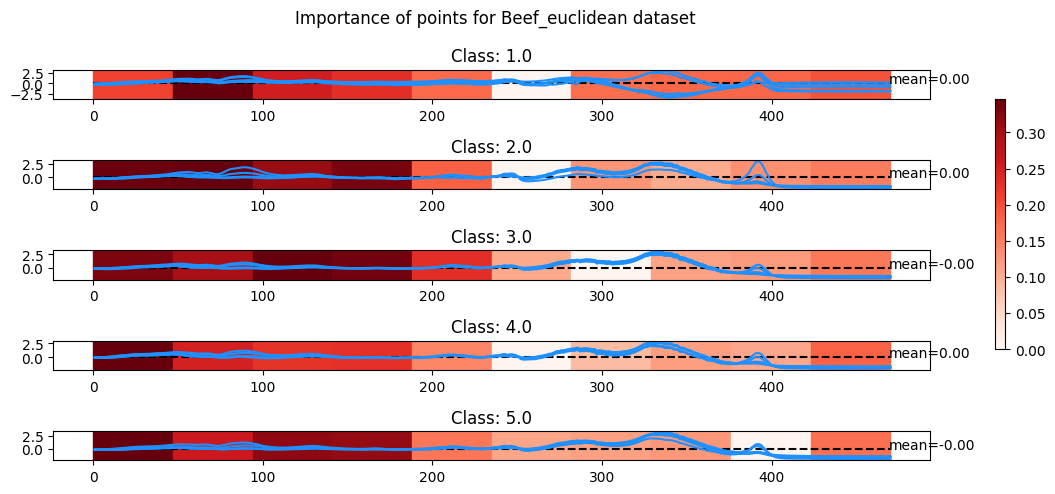

In [35]:
from fedot_ind.tools.explain.explain import PointExplainer

distance = 'euclidean'
explainer = PointExplainer(comp_model, X_test, y_test)
explainer.explain(n_samples=5, window=10, method=distance, name=dataset)
explainer.visual(threshold=0, name=dataset+'_'+distance)

Processing points: 100%|██████████| 10/10 [00:00<00:00, 10.32point/s]


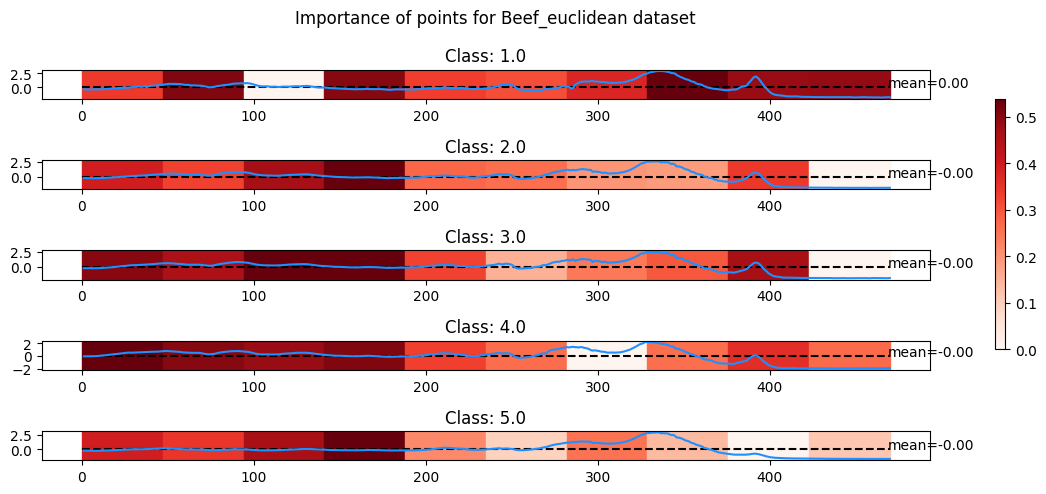

In [34]:
distance = 'euclidean'
explainer = PointExplainer(stat_model, X_test, y_test)
explainer.explain(n_samples=1, window=10, method=distance, name=dataset)
explainer.visual(threshold=0, name=dataset+'_'+distance)

Processing points: 100%|██████████| 10/10 [00:01<00:00,  8.87point/s]


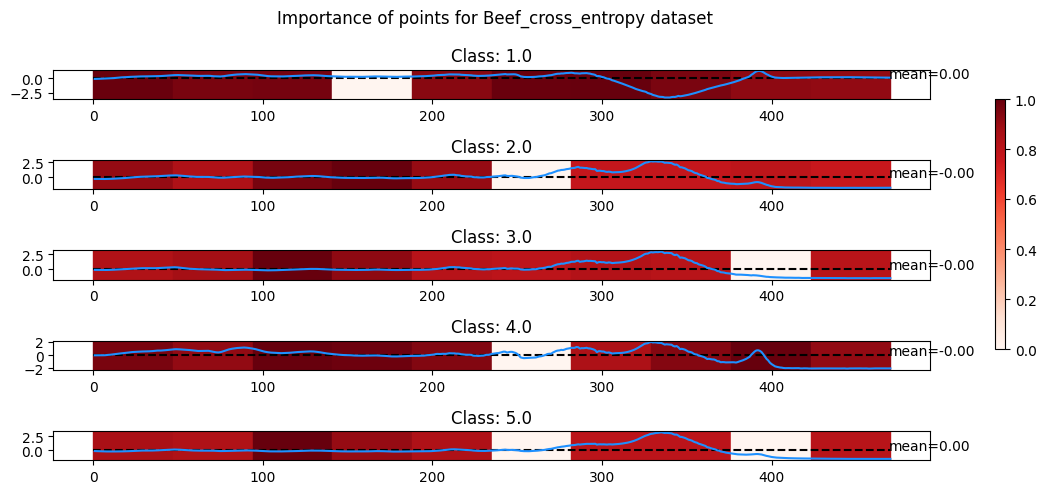

In [13]:
distance = 'cross_entropy'
explainer = PointExplainer(stat_model, X_test, y_test)
explainer.explain(n_samples=1, window=10, method=distance, name=dataset)
explainer.visual(threshold=0, name=dataset+'_'+distance)

Processing points: 100%|██████████| 10/10 [00:03<00:00,  2.58point/s]


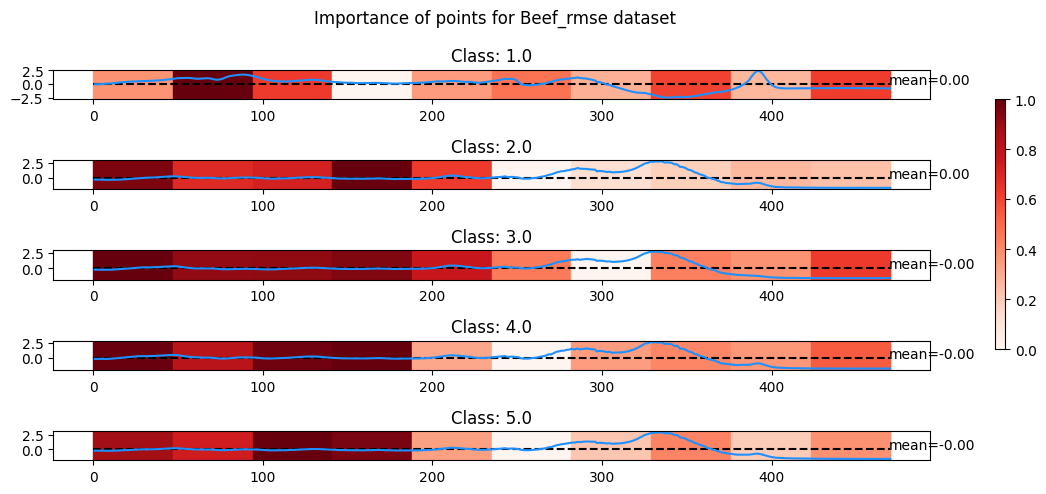

In [11]:
distance = 'rmse'
explainer = PointExplainer(comp_model, X_test, y_test)
explainer.explain(n_samples=1, window=10, method=distance, name=dataset)
explainer.visual(threshold=0, name=dataset+'_'+distance)

Processing points: 100%|██████████| 10/10 [00:03<00:00,  2.85point/s]


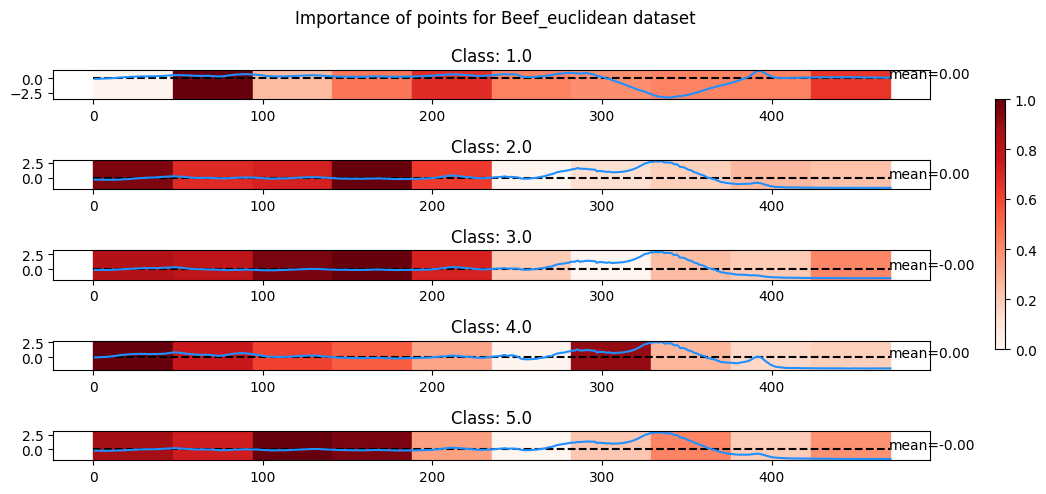

In [12]:
distance = 'euclidean'
explainer = PointExplainer(comp_model, X_test, y_test)
explainer.explain(n_samples=1, window=10, method=distance, name=dataset)
explainer.visual(threshold=0, name=dataset+'_'+distance)